# Intro

The goal in this note is to work with the data of COVID-19 cases to build and evaluate prediction models that capture the relationship between the descriptive features and the target feature death_yn.

The data has been cleaned from the original data provided by the Centers for Disease Control and Prevention (CDC: https://covid.cdc.gov/covid-data-tracker/) following the process below: 

|Variable Names|Data Quality Issue|Handling Strategy|Justification
|-|-|-|-
|case_month|No issue|-|-
|case_positive_specimen_interval|47% Missing|Drop|Too many are missing. Imputation can affect the prediction
|case_positive_specimen_interval|Outliers|Drop|89% non-missing values are 0, making all values that are different from 0 become ‘outliers’. Extraordinarily high frequency of 0 might be a serious error in data integration or manual entry.
|case_onset_interval|57% Missing||Only 3.39% is Invalid Missing, 52.65% is Valid Missing because the case is asymptomatic
|case_onset_interval|Outliers|Drop|96% non-missing values are 0, making all values that are different from 0 become ‘outliers’. Extraordinarily high frequency of 0 might be a serious error in data integration or manual entry. Part of the information is already reflected in feature symptom_status
|res_state|0.0025% Missing|Imputed as 'Missing'|Match with CDC encoding when data is not provided
|state_fips_code|0.0025% Missing|Imputed as 'Missing'|Match with CDC encoding when data is not provided
|res_county	37583|6.0425% Missing|Imputed as 'Missing'|Match with CDC encoding when data is not provided
|county_fips_code|6.0425% Missing|Imputed as 'Missing'|Match with CDC encoding when data is not provided
|age_group|0.6400% Missing|Imputed as 'Missing'|Match with CDC encoding when data is not provided
|sex|1.9700% Missing|Imputed as 'Missing'|Match with CDC encoding when data is not provided
|race|11.6625% Missing|Imputed as 'Missing'|Match with CDC encoding when data is not provided
|ethnicity|12.6775% Missing|Imputed as 'Missing'|Match with CDC encoding when data is not provided
|process|No issue|Leave as is|CDC encodes non-provided data to 'Missing', not that the actual dataset is missing
|exposure_yn|No issue|Leave as is|CDC encode non-provided data to 'Missing', not that the actual dataset is missing
|current_status|No issue|Leave as is|-|
|symptom_status|No issue|Leave as is|CDC encode non-provided data to 'Missing', not that the actual dataset is missing.
|hosp_yn|No issue|Leave as is|CDC encode non-provided data to 'Missing', not that the actual dataset is missing
|icu_yn|No issue|Leave as is|CDC encode non-provided data to 'Missing', not that the actual dataset is missing 
|death_yn|No issue|Leave as is|-|
|underlying_conditions_yn|91.3225% Missing|Drop features|Too many are missing


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold 

In [2]:
#Load the dataset
df = pd.read_csv("./covid19-cdc-cleaned-22201371-22202474-utf8.csv", low_memory=False)
df.shape

(40000, 16)

In [3]:
df.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn
0,2020-06-01,FL,12.0,PALM BEACH,12099.0,65+ years,Female,Black,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Missing,Yes
1,2020-12-01,CA,6.0,SANTA CLARA,6085.0,65+ years,Male,Missing,Missing,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Unknown,Yes
2,2020-11-01,TX,48.0,EL PASO,48141.0,65+ years,Male,White,Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Yes
3,2020-12-01,MN,27.0,CROW WING,27035.0,65+ years,Female,White,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Yes,Yes
4,2022-01-01,NJ,34.0,CAMDEN,34007.0,65+ years,Male,White,Non-Hispanic/Latino,Missing,Missing,Probable Case,Symptomatic,Yes,Missing,Yes


In [4]:
# Review the datatypes
df.dtypes

case_month          object
res_state           object
state_fips_code     object
res_county          object
county_fips_code    object
age_group           object
sex                 object
race                object
ethnicity           object
process             object
exposure_yn         object
current_status      object
symptom_status      object
hosp_yn             object
icu_yn              object
death_yn            object
dtype: object

In [5]:
# Select columns with object type
category = df.select_dtypes(['object']).columns

# Convert data type to category for these columns
for column in category:
    df[column] = df[column].astype('category')

In [6]:
df[category].head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn
0,2020-06-01,FL,12.0,PALM BEACH,12099.0,65+ years,Female,Black,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Missing,Yes
1,2020-12-01,CA,6.0,SANTA CLARA,6085.0,65+ years,Male,Missing,Missing,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Unknown,Yes
2,2020-11-01,TX,48.0,EL PASO,48141.0,65+ years,Male,White,Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Yes
3,2020-12-01,MN,27.0,CROW WING,27035.0,65+ years,Female,White,Non-Hispanic/Latino,Missing,Missing,Laboratory-confirmed case,Symptomatic,Yes,Yes,Yes
4,2022-01-01,NJ,34.0,CAMDEN,34007.0,65+ years,Male,White,Non-Hispanic/Latino,Missing,Missing,Probable Case,Symptomatic,Yes,Missing,Yes


# 1. [25] **Data Understanding and Preparation:** 

Exploring relationships between feature pairs and selecting/transforming promising features based on a given training set. 

#### The data has no continuous features.

## 1.1 Splitting the dataset: 70% training and 30% testing. The dataset has no continuous features.

In [7]:
target_feature = 'death_yn'
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != target_feature], 
                                                    df[[target_feature]], test_size=0.3, random_state=42)
print(df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40000, 16)
(28000, 15)
(28000, 1)
(12000, 15)
(12000, 1)


## 1.2 Categorical features' pairwise interaction with the target feature 

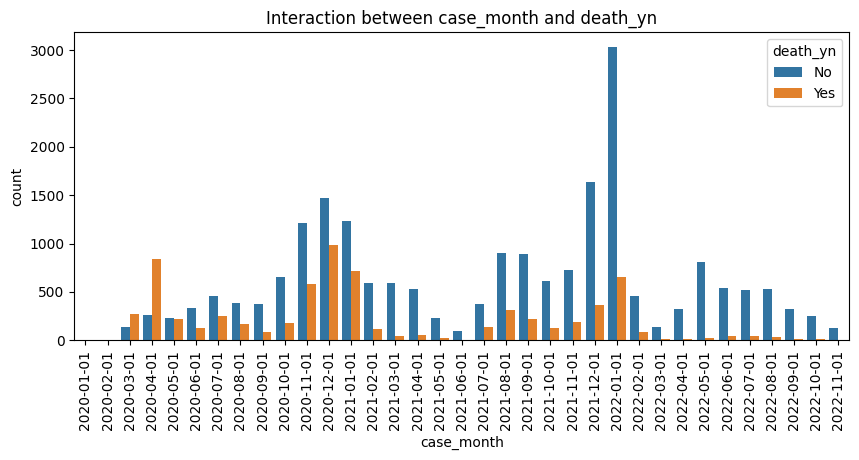

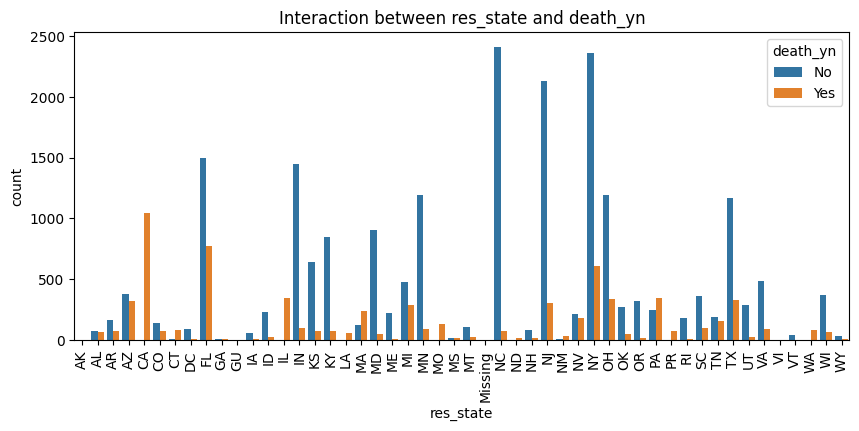

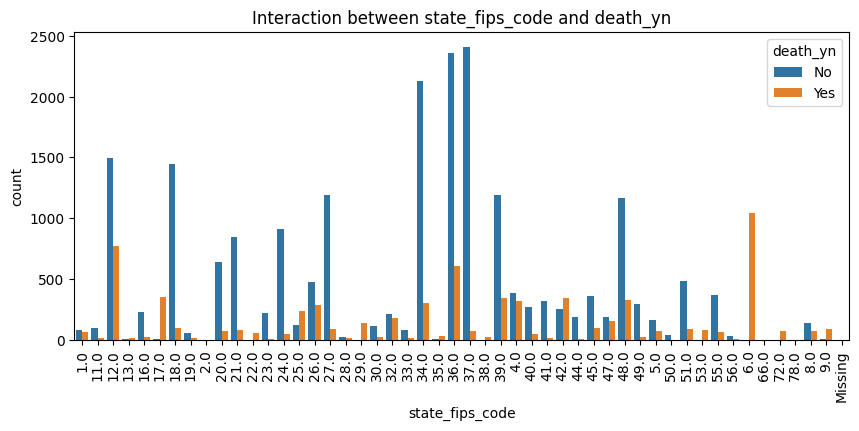

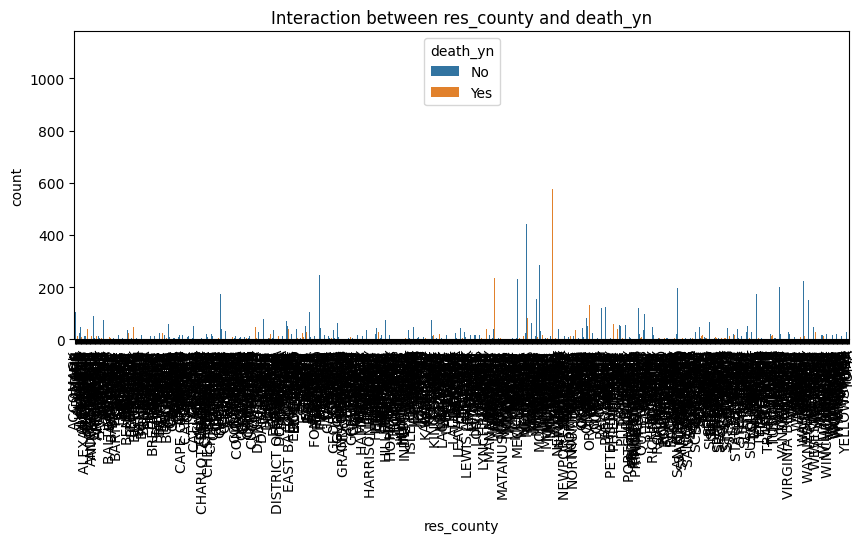

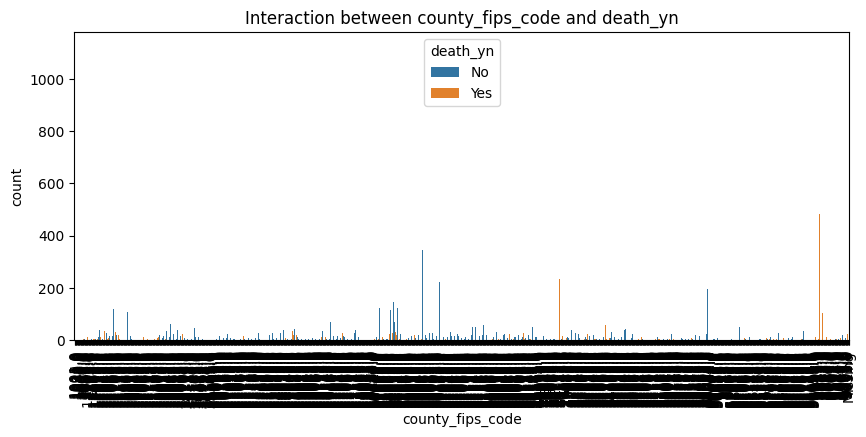

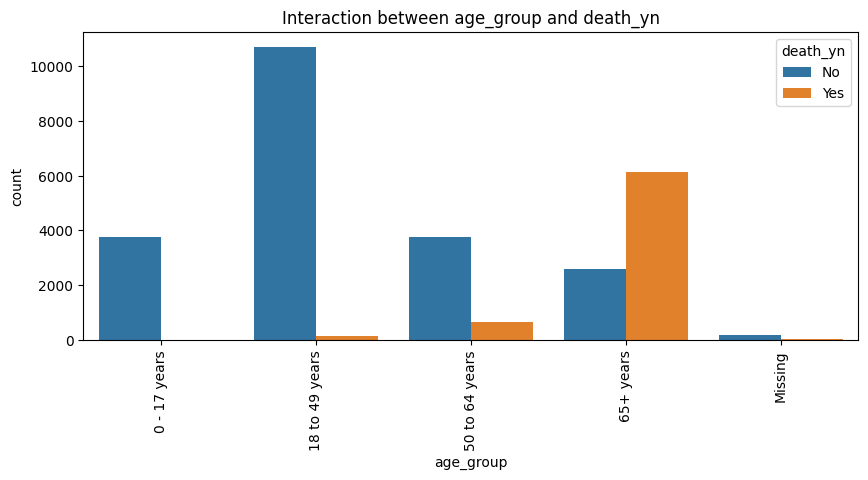

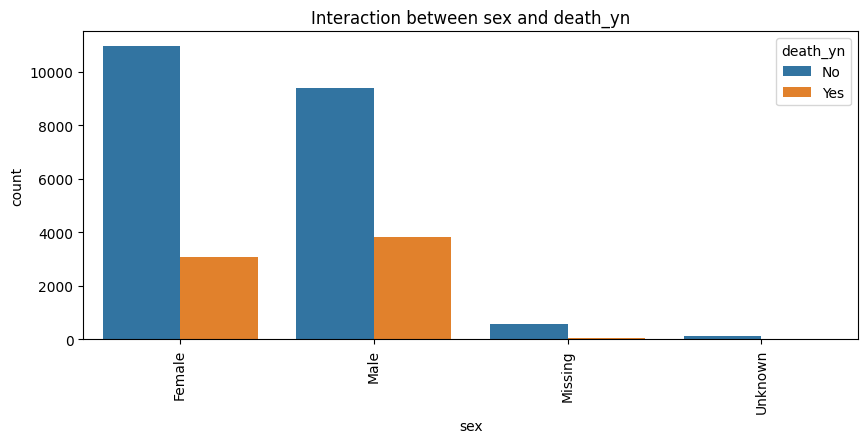

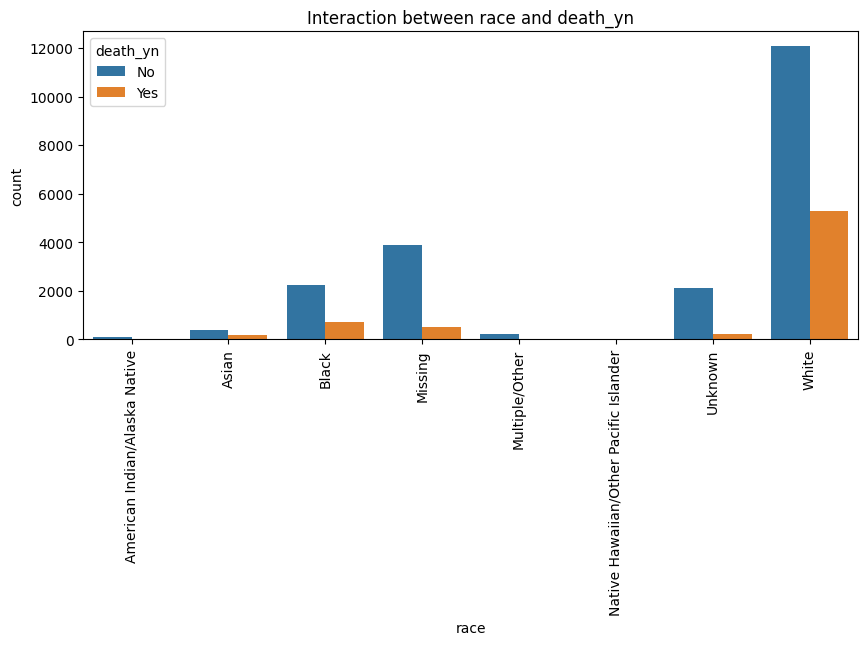

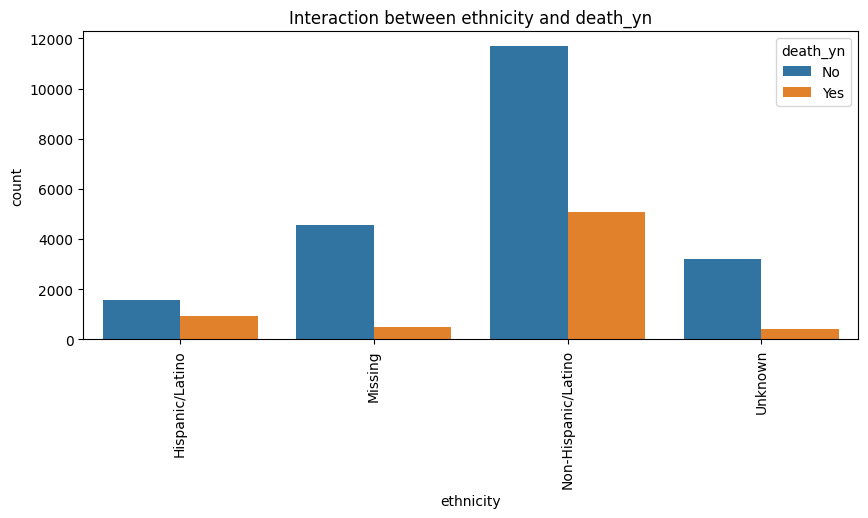

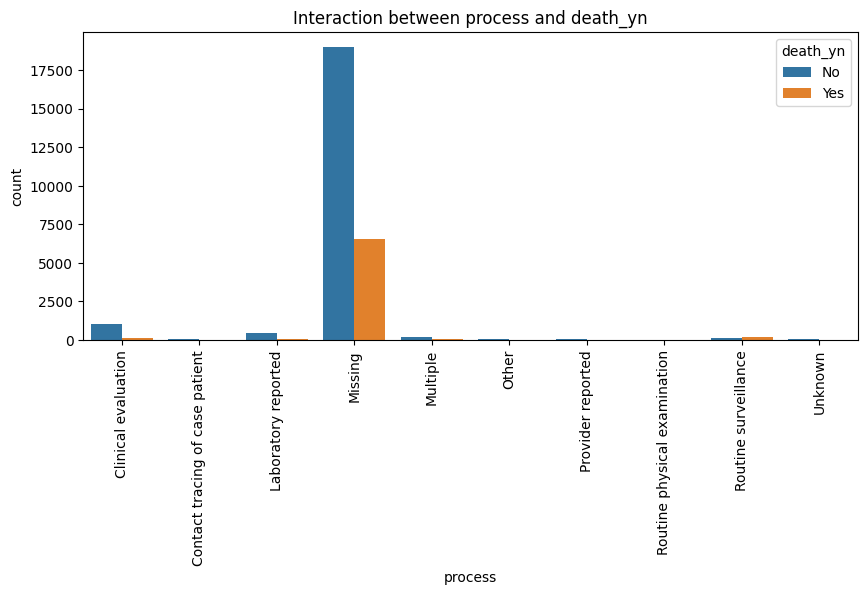

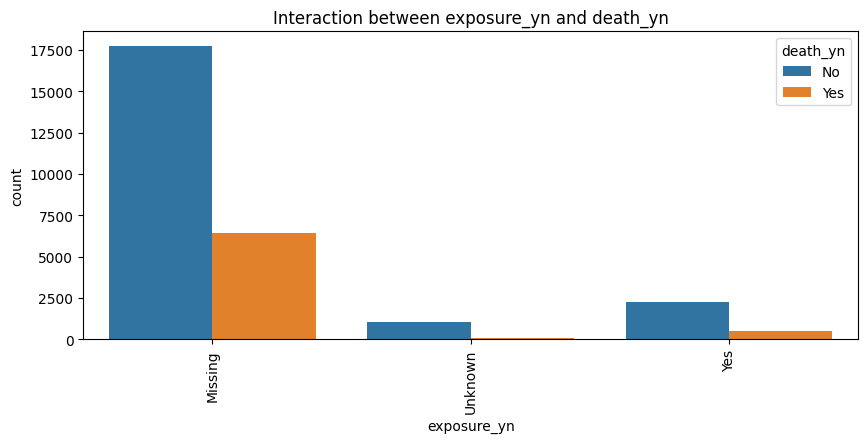

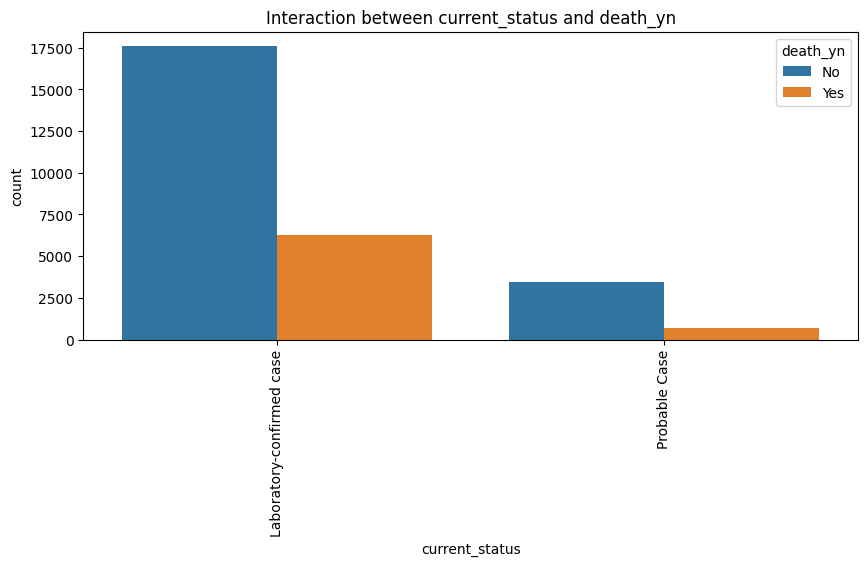

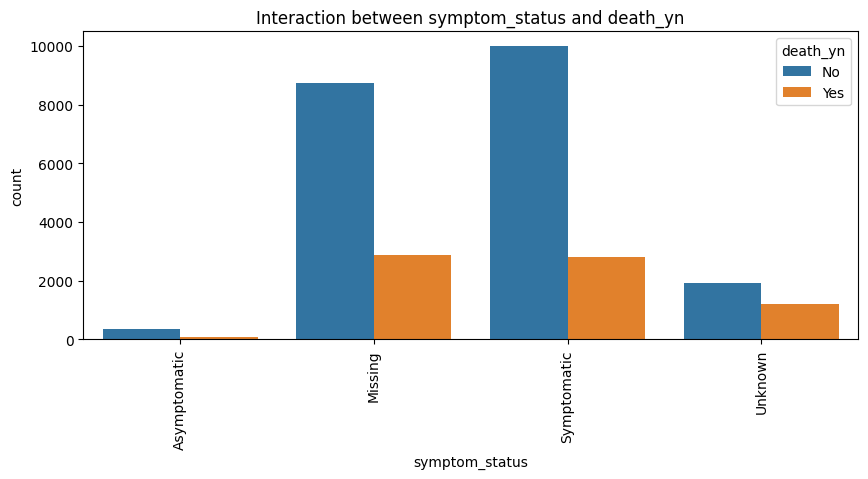

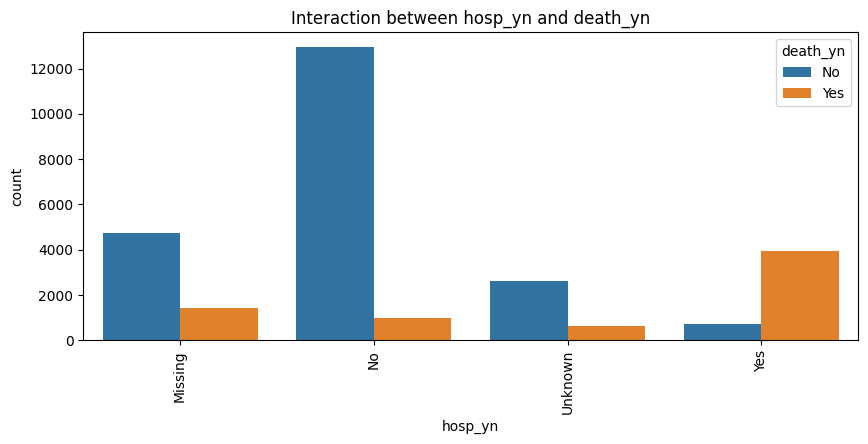

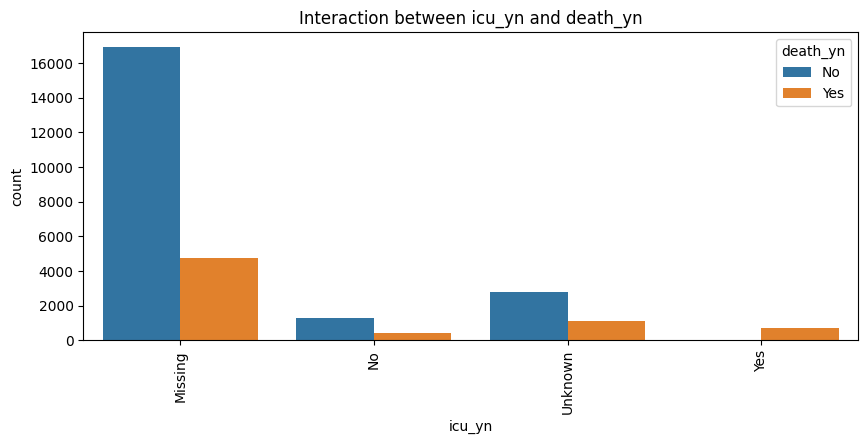

In [8]:
for feature in category:
    if feature != target_feature:
        plt.figure(figsize=(10,4))
        sns.countplot(x=feature, hue=target_feature, data=pd.concat([X_train,y_train],axis=1))
        plt.title(f"Interaction between {feature} and {target_feature}")
        plt.xticks(rotation=90)
        plt.show()

## ☞ Discussion:
### Promising features:

- case_month: The proportion of death seems to decrease overtime, especially after February 2021. Therefore, which month the case is can play a role in death outcome prediction. Also, it is believed that some weather conditions, which are affected by seasons and the time of the year, can affect the severity of a COVID-19 case. 
- res_state resprents the state of residence: The plot shows some states has really low death rate (such as NC, IN ...) while some states has really high death rate (such as CA, IN). Therefore, the state of residence can say something about the death probability. 
- age_group: The plot shows huge different in death outcome among different age groups, so age group is really promising in prediction
- sex: Male seems to have higher death rate than Female, so sex is promising in prediction
- race: 'Missing' and 'Unknown' races have far lower death rate, 'Black' has a low death rate too compared to 'While', so race is promising in prediction
- ethnicity: 'Missing' and 'Unknown' races have far lower death rate than other 2 ethicities, so this feature can be promising in prediction
- current_status: 
- symptom_status:
- hosp_yn: 
- icu_yn: 

### Not really promissing features: 
- state_fips_code: We already have res_state which shows same information. Also, it’s clearer to have the state acronym than just code, which requires further decoding when interpreting results. 
- res_county and county_fips_code represent the county of residence: The cardinality is too high, which makes the training subsets too small for a good model. Also, we already have state of residence to represent the geographical demography of a case, which is promising, for prediction. 
- exposure_yn: "Missing" is dominant so might bias the prediction. Also, this feature tells whether a patient is in contact with others, which tells more about the source of the virus than about the death outcome of a COVID-19 case. 

## 1.3 Prepare data for predictive modeling

In [9]:
# Select the promising features:
predictive_feature = ["case_month", "res_state", "age_group", "sex", "race", "ethnicity", "current_status", 
                      "symptom_status","hosp_yn","icu_yn"]

target_feature = "death_yn"

### Full dataset

In [10]:
# Create dummy variables to represent categorical data
X = df[predictive_feature]
X = pd.get_dummies(X)
X.shape

(40000, 120)

In [11]:
# Assign target feature to Y
y = df[target_feature]
y.shape

(40000,)

In [12]:
# create new series for to represent target feature in numeric format
y_lnr = y.map({'Yes':1, 'No':0})
y_lnr.shape

(40000,)

### Training dataset

In [13]:
# Create dummy variables to represent categorical data
X_train = X_train[predictive_feature]
X_train = pd.get_dummies(X_train)
X_train.shape

(28000, 120)

In [14]:
# Assign target feature to Y
y_train = y_train[target_feature]
y_train.shape

(28000,)

In [15]:
# create new series for to represent target feature in numeric format 1 0
y_train_nmr = y_train.map({'Yes':1, 'No':0})
y_train_nmr.shape

(28000,)

### Testing dataset

In [16]:
# Create dummy variables to represent categorical data
X_test = X_test[predictive_feature]
X_test = pd.get_dummies(X_test)
X_test.shape

(12000, 120)

In [17]:
# Assign target feature to Y
y_test = y_test[target_feature]
y_test.shape

(12000,)

In [18]:
# create new series for to represent target feature in numeric format
y_test_nmr = y_test.map({'Yes':1, 'No':0})
y_test_nmr.shape

(12000,)

# 2. [15] Predictive Modeling: Linear Regression.  

## 2.1 On the training set, train a linear regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. 

In [19]:
# Train the linear regression model using train dataset
lnr = LinearRegression()
lnr.fit(X_train, y_train_nmr)

LinearRegression()

## 2.2 Print the coefficients learned by the model and discuss their role in the model 

(e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature)

In [20]:
# Print the intercept and weights learned for each feature.
print("\nIntercept: \n", lnr.intercept_)
feature_importance = pd.DataFrame({'feature': X_train.columns.values, 'importance':lnr.coef_[0]})
feature_importance.sort_values('importance', ascending=False)


Intercept: 
 -1507070177.8930266


,feature,importance
0,case_month_2020-01-01,-1.753744e+10
1,case_month_2020-02-01,-1.753744e+10
88,age_group_65+ years,-1.753744e+10
87,age_group_50 to 64 years,-1.753744e+10
86,age_group_18 to 49 years,-1.753744e+10
...,...,...
35,res_state_AK,-1.753744e+10
34,case_month_2022-11-01,-1.753744e+10
33,case_month_2022-10-01,-1.753744e+10
32,case_month_2022-09-01,-1.753744e+10


## 2.3 Print the predicted target feature value for the first 10 training examples. 

Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.

In [21]:
#Predict the target feature value for the first 10 training examples:
y_pred_train = lnr.predict(X_train)
print("Predicted target feature values for the first 10 training examples:", y_pred_train[:10])

Predicted target feature values for the first 10 training examples: [ 0.10874343  1.0215776   0.5465486   0.47184157 -0.0535872   0.11687636
  0.12287307 -0.0391295   0.7343843   0.01340652]


In [22]:
#Threshold the predicted target feature value and print the predicted class for the first 10 examples:
y_pred_train_class = (y_pred_train >= 0.5).astype(int)
print("Predicted class for the first 10 training examples:", y_pred_train_class[:10])

Predicted class for the first 10 training examples: [0 1 1 0 0 0 0 0 1 0]


In [23]:
#Calculate and print classification evaluation measures for the full training set
accuracy = accuracy_score(y_train_nmr, y_pred_train_class)
conf_matrix = confusion_matrix(y_train_nmr, y_pred_train_class)
precision = precision_score(y_train_nmr, y_pred_train_class)
recall = recall_score(y_train_nmr, y_pred_train_class)
f1 = f1_score(y_train_nmr, y_pred_train_class)

print("Accuracy:", accuracy)
print("Confusion Matrix:", conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9466071428571429
Confusion Matrix: [[20415   620]
 [  875  6090]]
Precision: 0.9076005961251863
Recall: 0.8743718592964824
F1 Score: 0.8906764168190128


## ☞ Evaluate the model on training set:

Accuracy 0.947 suggests that the classification model has a high overall accuracy, which means that the model correctly predicted the class of approximately 94.7% of the test data. However, accuracy alone may not provide the complete picture of the model's performance, and other metrics such as precision, recall, and F1 score can provide additional insights.

The confusion matrix indicates that the model correctly classified 20415 instances as true negatives and 6090 instances as true positives, while misclassifying 620 instances as false positives and 875 instances as false negatives. This suggests that the model has a higher rate of correctly identifying negative instances than positive instances.

The precision of the model is 0.907, which means that out of all the instances that the model predicted as positive, 90.7% were actually positive. 

The recall of the model is 0.874, which means that out of all the positive instances in the test set, the model correctly identified 87.4%. In this specific problem of predicting death outcome of COVID19 patient, mispredict "Yes" death outcome as "No" can cause negative consequences such as lack of clinical treatment for cases that can die but have been predicted as not dying. Therefore, 87.4% seems good but should be improved.

The F1 score, which is a weighted average of precision and recall and balances the tradeoff between precision and recall, is 0.891. This indicates that the model has good overall balance between correctly identifying positive instances (recall) and correctly predicting the class of positive instances (precision). However, there is still room for improvement, especially in Type II error.

Overall, the results suggest that the model has relatively high accuracy and precision, but may have lower recall and misclassifies a non-negligible number of positive instances as negative, which means that it mispredict "Yes" death outcome as "No" and this may cause negative consequences. 

## 2.4 Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set

Compare these results with the evaluation results obtained on the training (70%) dataset. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings.

In [25]:
#Evaluate the model on the hold-out test set:
y_pred_test = lnr.predict(X_test)
y_pred_test_class = (y_pred_test >= 0.5).astype(int)

accuracy_test = accuracy_score(y_test_nmr, y_pred_test_class)
conf_matrix_test = confusion_matrix(y_test_nmr, y_pred_test_class)
precision_test = precision_score(y_test_nmr, y_pred_test_class)
recall_test = recall_score(y_test_nmr, y_pred_test_class)
f1_test = f1_score(y_test_nmr, y_pred_test_class)

print("Test Accuracy:", accuracy_test)
print("Test Confusion Matrix:", conf_matrix_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)
print("Test F1 Score:", f1_test)

Test Accuracy: 0.9444166666666667
Test Confusion Matrix: [[8704  261]
 [ 406 2629]]
Test Precision: 0.9096885813148788
Test Recall: 0.8662273476112027
Test F1 Score: 0.8874261603375527


### ☞ Evaluate the model on the hold-out test set:

All metrics are a little lower than when running on the training set, but still indicates the same about the quality of the regression model: the model has relatively high accuracy and precision, but have lower recall and misclassifies a non-negligible number of positive instances as negative, which means that it mispredict "Yes" death outcome as "No" and this may cause negative consequences.

In [26]:
# Cross validation using classic kfold
# Define the number of folds
n_splits = 5

# Initialize the KFold object
kf = KFold(n_splits=n_splits, shuffle=True)
kf.get_n_splits(X)

5

In [27]:
# Create empty lists to store the scores for all folds
accuracy = []
precision = []
recall = []
f1 = []

# Loop over the folds
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Fold",i,"- Classification evaluation measures: ")

    # Split the data into training and validation sets
    X_train, y_train = X.iloc[train_index], y_lnr.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y_lnr.iloc[val_index]
    
    # Fit the model on the training data
    lnr.fit(X_train, y_train)
    
    # Predict the target variable on the validation data
    y_pred = lnr.predict(X_val)
    y_pred_class = (y_pred >= 0.5).astype(int)
    
    # Calculate the evaluation measures and append to the corresponding lists
    accuracy_val = accuracy_score(y_val, y_pred_class)
    accuracy.append(accuracy_val)
    
    precision_val = precision_score(y_val, y_pred_class)
    precision.append(precision_val)
    
    recall_val = recall_score(y_val, y_pred_class)
    recall.append(recall_val)
    
    f1_val = f1_score(y_val, y_pred_class)
    f1.append(f1_val)
    
    
    print("Accuracy:", accuracy_val, "|",
          "Precision:", precision_test,"|", 
          "Recall:", recall_val,"|", 
          "f1:", f1_val)    


Fold 0 - Classification evaluation measures: 
Accuracy: 0.948125 | Precision: 0.9096885813148788 | Recall: 0.8843606724401426 | f1: 0.8932338564445588
Fold 1 - Classification evaluation measures: 
Accuracy: 0.944375 | Precision: 0.9096885813148788 | Recall: 0.8694556451612904 | f1: 0.8857509627727855
Fold 2 - Classification evaluation measures: 
Accuracy: 0.943375 | Precision: 0.9096885813148788 | Recall: 0.8675171736997056 | f1: 0.8864377036851341
Fold 3 - Classification evaluation measures: 
Accuracy: 0.944125 | Precision: 0.9096885813148788 | Recall: 0.8738107160741112 | f1: 0.8864617729235459
Fold 4 - Classification evaluation measures: 
Accuracy: 0.945 | Precision: 0.9096885813148788 | Recall: 0.8716551040634292 | f1: 0.888832743810005


In [28]:
# Print the mean and standard deviation of the scores across all folds
print("Average Accuracy score: {:.2f} (+/- {:.2f})".format(np.mean(accuracy), np.std(accuracy)))
print("Average Precision score: {:.2f} (+/- {:.2f})".format(np.mean(precision), np.std(precision)))
print("Average Recall score: {:.2f} (+/- {:.2f})".format(np.mean(recall), np.std(recall)))
print("Average f1 score: {:.2f} (+/- {:.2f})".format(np.mean(f1), np.std(f1)))

Average Accuracy score: 0.95 (+/- 0.00)
Average Precision score: 0.90 (+/- 0.00)
Average Recall score: 0.87 (+/- 0.01)
Average f1 score: 0.89 (+/- 0.00)


# 4 Random forest model

In [29]:
# 4.1 train the random forest model on the training set
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# 4.3 Predict the target feature values and classes for the first 10 training examples, and compute evaluation metrics on the full training set
y_train_rf_pred = rf.predict(X_train)
y_train_rf_pred_prob = rf.predict_proba(X_train)[:, 1]

print("Predicted target feature values for the first 10 training examples:")
print(y_train_rf_pred_prob[:10])
print("Predicted class for the first 10 training examples:")
print(y_train_rf_pred[:10])


Predicted target feature values for the first 10 training examples:
[1.         1.         0.96       1.         0.96       1.
 0.96       1.         0.95466667 1.        ]
Predicted class for the first 10 training examples:
[1 1 1 1 1 1 1 1 1 1]


In [31]:
accuracy_rf = accuracy_score(y_train, y_train_rf_pred)
conf_matrix_rf = confusion_matrix(y_train, y_train_rf_pred)
precision_rf = precision_score(y_train, y_train_rf_pred, pos_label=1)
recall_rf = recall_score(y_train, y_train_rf_pred, pos_label=1)
f1_rf = f1_score(y_train, y_train_rf_pred, pos_label=1)

print("Accuracy:", accuracy_rf)
print("Confusion Matrix:\n", conf_matrix_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

Accuracy: 0.9859375
Confusion Matrix:
 [[23766   252]
 [  198  7784]]
Precision: 0.9686411149825784
Recall: 0.9751941869205712
F1 Score: 0.971906605069297


In [32]:
y_test_rf_pred = rf.predict(X_test)
print(y_test_rf_pred.shape)
print(y_test.shape)
test_accuracy_rf = accuracy_score(y_test_nmr, y_test_rf_pred)
test_precision_rf = precision_score(y_test_nmr, y_test_rf_pred, pos_label=1)
test_recall_rf = recall_score(y_test_nmr, y_test_rf_pred, pos_label=1)
test_f1_rf = f1_score(y_test_nmr, y_test_rf_pred, pos_label=1)

print("Test Accuracy:", test_accuracy_rf)
print("Test Precision:", test_precision_rf)
print("Test Recall:", test_recall_rf)
print("Test F1 Score:", test_f1_rf)

(12000,)
(12000,)
Test Accuracy: 0.9781666666666666
Test Precision: 0.9583471074380165
Test Recall: 0.9551894563426688
Test F1 Score: 0.9567656765676568


In [ ]:
# 4.4 Evaluate the model on the hold-out test set, compare results with the training dataset, and perform cross-validation

y_test_rf_pred = rf.predict(X_test)
test_accuracy_rf = accuracy_score(y_test_nmr, y_test_rf_pred)
test_precision_rf = precision_score(y_test_nmr, y_test_rf_pred, pos_label=1)
test_recall_rf = recall_score(y_test_nmr, y_test_rf_pred, pos_label=1)
test_f1_rf = f1_score(y_test_nmr, y_test_rf_pred, pos_label=1)

print("Test Accuracy:", test_accuracy_rf)
print("Test Precision:", test_precision_rf)
print("Test Recall:", test_recall_rf)
print("Test F1 Score:", test_f1_rf)

rf_cv = RandomForestClassifier(random_state=42)
accuracy_scores_rf = cross_val_score(rf_cv, X, y, cv=5, scoring='accuracy')
precision_scores_rf = cross_val_score(rf_cv, X, y, cv=5, scoring='precision_macro')
recall_scores_rf = cross_val_score(rf_cv, X, y, cv=5, scoring='recall_macro')
f1_scores_rf = cross_val_score(rf_cv, X, y, cv=5, scoring='f1_macro')

print("Cross-validated Accuracy:", np.mean(accuracy_scores_rf))
print("Cross-validated Precision:", np.mean(precision_scores_rf))
print("Cross-validated Recall:", np.mean(recall_scores_rf))
print("Cross-validated F1 Score:", np.mean(f1_scores_rf))

Test Accuracy: 0.9781666666666666
Test Precision: 0.9583471074380165
Test Recall: 0.9551894563426688
Test F1 Score: 0.9567656765676568
